<a href="https://colab.research.google.com/github/aquila00/user_based/blob/main/MovieIt_user.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sistema de Filtragem colaborativa - User Based

##Database:

This dataset (ml-25m) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service.

It contains:

* 25.000.095 ratings;
*  1.093.360 tag applications;
*    62.423 movies.

Ratings: 0.5 stars - 5.0 stars

These data were created by 162.541 users between January 09, 1995 and November 21, 2019. 

This dataset was generated on November 21, 2019.

#Pré processamento

##Bibliotecas

In [ ]:
# Gerais
import pandas as pd
import numpy as np
import math

# Para separação de treino-teste
from sklearn.model_selection import train_test_split

# Para o RMSE
from sklearn.metrics import mean_squared_error

# Plot
import matplotlib.pyplot as plt
from pylab import title, xlabel, ylabel

# Google drive / Colab
from google.colab import drive

In [ ]:
# Acessando os arquivos no GoogleDrive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##Database

### Ratings

In [ ]:
# 1 milhão
path = '/content/gdrive/MyDrive/movieit/ml-1m'
db_rating = pd.read_csv(f'{path}/ratings.dat', names=['userid', 'movieid', 'rating', 'timestamp'], usecols=['userid', 'movieid', 'rating'], skiprows=1, header=None, sep='::')

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


### Gêneros

In [ ]:
# gêneros
db_movie = pd.read_csv(f'{path}/movies.dat', names=['movieid', 'movietitle', 'genres'], skiprows=1, header=None, sep='::')

In [ ]:
db_movie

,movieid,movietitle,genres
0,2,Jumanji (1995),Adventure|Children's|Fantasy
1,3,Grumpier Old Men (1995),Comedy|Romance
2,4,Waiting to Exhale (1995),Comedy|Drama
3,5,Father of the Bride Part II (1995),Comedy
4,6,Heat (1995),Action|Crime|Thriller
...,...,...,...
3877,3948,Meet the Parents (2000),Comedy
3878,3949,Requiem for a Dream (2000),Drama
3879,3950,Tigerland (2000),Drama
3880,3951,Two Family House (2000),Drama


##Exploratória

In [ ]:
db_rating

,userid,movieid,rating
0,1,661,3
1,1,914,3
2,1,3408,4
3,1,2355,5
4,1,1197,3
...,...,...,...
1000203,6040,1091,1
1000204,6040,1094,5
1000205,6040,562,5
1000206,6040,1096,4


In [ ]:
n_ratings = len(db_rating)
n_ratings: int = len(db_rating)
n_users = len(db_rating['userid'].unique())
n_movies_avaliados = len(db_rating['movieid'].unique())
esparsidade = round(1.0 - n_ratings/float(n_users * n_movies_avaliados), 3)

print(f'Total de ratings: {n_ratings}\n'\
      f'Total de usuários únicos: {n_users}\n'\
      f'Total de filmes: {n_movies_avaliados}\n'\
      f'Média de ratings/user: {round(n_ratings/n_users, 2)}\n'\
      f'Esparsidade da base é de: {(esparsidade*100)}%'\
      f'\n')

print(f'{db_rating.info()}')

Total de ratings: 1000208
Total de usuários únicos: 6040
Total de filmes: 3706
Média de ratings/user: 165.6
Esparsidade da base é de: 95.5%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000208 entries, 0 to 1000207
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype
---  ------   --------------    -----
 0   userid   1000208 non-null  int64
 1   movieid  1000208 non-null  int64
 2   rating   1000208 non-null  int64
dtypes: int64(3)
memory usage: 22.9 MB
None


## Criando os conjuntos de treino e teste

**Considerações:**

Os conjuntos de treino e de teste foram criados pelos ids dos usuários uma vez que o conjunto da votação de um usuário compõe a integridade de suas preferências. 

A separação dos dados sem considerar esta integridade geraria problemas de particionamento do perfil do usuário alterando o resultado da similaridade.

In [ ]:
# matriz dos ids únicos dos usuários para a refereência do particionamento treino e teste
print(db_rating.userid.unique())

[   1    2    3 ... 6038 6039 6040]


In [ ]:
# Separando o conjunto de treino e de teste, deixando 10% dos usuários para futuros testes
X_train, X_test = train_test_split(db_rating.userid.unique(), test_size=0.2, random_state=700)

In [ ]:
# retornando os valores de filmes e de ratings para completar a matriz de treino
X_train = db_rating.loc[db_rating['userid'].isin(X_train)]

# retornando os valores de filmes e de ratings para completar a matriz de teste
X_test = db_rating.loc[db_rating['userid'].isin(X_test)]

### X_train - Exploratória

In [ ]:
X_train.head()

,userid,movieid,rating
52,2,1357,5
53,2,3068,4
54,2,1537,4
55,2,647,3
56,2,2194,4


In [ ]:
X_train.count()

userid     807160
movieid    807160
rating     807160
dtype: int64

In [ ]:
X_train.head()

,userid,movieid,rating
52,2,1357,5
53,2,3068,4
54,2,1537,4
55,2,647,3
56,2,2194,4


In [ ]:
n_ratings = len(X_train)
n_users = len(X_train['userid'].unique())
n_movies_avaliados = len(X_train['movieid'].unique())
esparsidade = round(1.0 -n_ratings/float(n_users * n_movies_avaliados),3)

print(f'Total de ratings: {n_ratings}\n'\
      f'Total de usuários únicos: {n_users}\n'\
      f'Total de filmes: {n_movies_avaliados}\n'\
      f'Média de ratings/user: {round(n_ratings/n_users, 2)}\n'\
      f'Esparsidade da base é de: {(esparsidade*100)}%'\
      f'\n')

print(f'{db_rating.info()}')

Total de ratings: 807160
Total de usuários únicos: 4832
Total de filmes: 3691
Média de ratings/user: 167.04
Esparsidade da base é de: 95.5%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000208 entries, 0 to 1000207
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype
---  ------   --------------    -----
 0   userid   1000208 non-null  int64
 1   movieid  1000208 non-null  int64
 2   rating   1000208 non-null  int64
dtypes: int64(3)
memory usage: 22.9 MB
None


### X_test - Exploratória

In [ ]:
X_test.head()

,userid,movieid,rating
0,1,661,3
1,1,914,3
2,1,3408,4
3,1,2355,5
4,1,1197,3


In [ ]:
X_test.count()

userid     193048
movieid    193048
rating     193048
dtype: int64

In [ ]:
X_test.head()

,userid,movieid,rating
0,1,661,3
1,1,914,3
2,1,3408,4
3,1,2355,5
4,1,1197,3


In [ ]:
n_ratings = len(X_test)
n_users = len(X_test['userid'].unique())
n_movies_avaliados = len(X_test['movieid'].unique())
esparsidade = round(1.0 -n_ratings/float(n_users * n_movies_avaliados),3)

print(f'Total de ratings: {n_ratings}\n'\
      f'Total de usuários únicos: {n_users}\n'\
      f'Total de filmes: {n_movies_avaliados}\n'\
      f'Média de ratings/user: {round(n_ratings/n_users, 2)}\n'\
      f'Esparsidade da base é de: {(esparsidade*100)}%'\
      f'\n')

print(f'{db_rating.info()}')

Total de ratings: 193048
Total de usuários únicos: 1208
Total de filmes: 3446
Média de ratings/user: 159.81
Esparsidade da base é de: 95.39999999999999%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000208 entries, 0 to 1000207
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype
---  ------   --------------    -----
 0   userid   1000208 non-null  int64
 1   movieid  1000208 non-null  int64
 2   rating   1000208 non-null  int64
dtypes: int64(3)
memory usage: 22.9 MB
None


# Recomendando filme para usuário único

## Filtrando a base

### Funções

In [ ]:
def instanciando_usuario_unico(id_userunico):
    """O "uservip" é instanciado a partir de um um usuário real do conjunto X_test visando a otimização de tempo para a criação de um novo usuário."""

    # Uma amostra do X_test para otimização de tempo, utilizando o id informado na variável id_arbitrario
    userunico = X_test.loc[X_test['userid'] == id_userunico]

    return userunico

In [ ]:
def criar_base_para_correlacao(X_treino, usuario):
    """Seleciona todos os usuários da base de treino que tenham assistido pelo menos um filme em comum com o "usuario" e o próprio usuario, pivotados"""

    base = X_treino.loc[X_treino['movieid'].isin(usuario['movieid'])]

    # Adiciona o usuario à tabela para que o número de colunas seja igual ao da base e para, futuramente, fazer a correlação
    base = pd.concat([base, usuario], ignore_index=True, axis='index')

    base_pivotada = base.pivot_table(index='userid', columns='movieid', values='rating')

    return base_pivotada

In [ ]:
def calculando_correlacao(base, id_user, metodo='pearson'):
    """Calculando pearson por default"""

    uservip_corr = base.T.corr(method=metodo)
    uservip_corr.drop(index=id_user, inplace=True)
    uservip_corr = uservip_corr[id_user]
    uservip_corr = uservip_corr[uservip_corr>0]
    similaridades = uservip_corr.to_list()
    indexes = uservip_corr.index.to_list()    
    dicionario = dict(zip(indexes, similaridades))
    
    return dicionario

In [ ]:
def criar_base_para_recomendacao(X_treino, usuario, dicionario_vizinhos_pesos):
    """remove o usuário da base com todos filmes que os vizinhos do usuario assistiram"""

    base_user = X_treino.loc[~X_treino['movieid'].isin(usuario['movieid']) & X_treino['userid'].isin(list(dicionario_vizinhos_pesos.keys()))]
    base_user['similaridade'] = [dicionario_vizinhos_pesos[X_treino['userid'][index]] for index in base_user.index]

    return base_user

In [ ]:
#retorna o valor do coeficiente de pearson 
def valor_item(base, filme):
    """Verifica a nota do item não consumido pelo usuário novo, com base nos usuários vizinhos"""

    base = base.loc[base['movieid'] == filme]

    resultado = 0
    divisor = 0
    
    for linha in base.index:
        valor = base.loc[base.index == linha, 'rating'].iloc[0]
        similaridade = base.loc[base.index == linha, 'similaridade'].iloc[0]
        
        resultado = resultado + valor * similaridade
        divisor = divisor + similaridade

    try:
        resultado = resultado / divisor     
    except ZeroDivisionError:
        resultado = 0

    return resultado

In [ ]:
def recomendacoes(base_treino, userid=1, metodo_de_calculo='pearson', rmse=False):
    user = instanciando_usuario_unico(userid)

    if rmse == True:
        user_original = user.copy()
        quantidade = math.floor(len(user_original.index) * 0.4)
        drop_index = np.random.choice(user.index, quantidade, replace=False)

        user_original = user_original[user_original.index.isin(list(drop_index))]
        user = user.drop(drop_index)

    db_corr = criar_base_para_correlacao(base_treino, user)

    correlacao = calculando_correlacao(db_corr, userid, metodo_de_calculo)

    db_rec = criar_base_para_recomendacao(base_treino, user, correlacao)

    #Cria o vetor contendo os dados do usuário novo usuário para teste alterar o valor 0
    nova_linha = [valor_item(db_rec, j) for j in db_rec.movieid.unique()]

    # Cria a variável que armazena os filmes a serem recomendados de acordo com os critérios de similaridade
    filmes_recomendados = [[resultado, filme] for resultado, filme in 
                          zip(nova_linha, db_rec.movieid.unique()) 
                          if resultado != 0]

    if rmse == True:
        extra = [[userid, resultado[1], resultado[0]] 
                 for resultado in filmes_recomendados 
                 if resultado[1] in user_original.movieid.unique()]

        extra = pd.DataFrame(extra, columns=user_original.columns)

        return user_original, extra
    else:
        return filmes_recomendados

### Recomendando

In [ ]:
#ordena os filmes por ordem ascendente de notas e printa a nota na tela
filmes_recomendados = recomendacoes(X_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
filmes_recomendados.sort(reverse=True)

In [ ]:
filmes_recomendados

[[5.000000000000001, 1002],
 [5.0, 3888],
 [5.0, 3881],
 [5.0, 3800],
 [5.0, 3609],
 [5.0, 3517],
 [5.0, 3293],
 [5.0, 3245],
 [5.0, 3172],
 [5.0, 2930],
 [5.0, 1795],
 [5.0, 1420],
 [5.0, 439],
 [4.999999999999999, 3443],
 [4.999999999999998, 1886],
 [4.931049300705509, 981],
 [4.922967104806182, 53],
 [4.857742318504142, 2309],
 [4.805436600138677, 3880],
 [4.803541018328987, 2839],
 [4.7941678429301335, 2197],
 [4.778185832355201, 3645],
 [4.767636601721885, 3495],
 [4.766885727399379, 3570],
 [4.723467016364002, 559],
 [4.653074264564551, 2905],
 [4.6335738929164005, 2358],
 [4.618077849852296, 2281],
 [4.616861589947478, 326],
 [4.615779153206457, 318],
 [4.607451875030408, 1715],
 [4.605108033124698, 3134],
 [4.594530170031491, 116],
 [4.592354987644335, 2999],
 [4.591619091249445, 363],
 [4.590329422433737, 2562],
 [4.59018087475198, 3232],
 [4.585909676529329, 687],
 [4.5797107282718805, 2831],
 [4.574178069455093, 3746],
 [4.5692030525225205, 858],
 [4.56795669532441, 2731],
 

In [ ]:
#for i in range(20):
#    print(f"{i+1} - {db_movie.loc[db_movie['movieid']==filmes_recomendados[i][1], 'movietitle'].values[0]}"
#            #f"- Gênero(s): {db_movie.loc[db_movie['movieid']==filmes_recomendados[i][1], 'generos'].values[0]}"
#            f"- Nota: {round(filmes_recomendados[i][0], 2)}")

# Medidas de avaliação

In [ ]:
users = np.random.choice(X_test.userid.unique(), 3, replace=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


RMSE:
0.6365571253523353


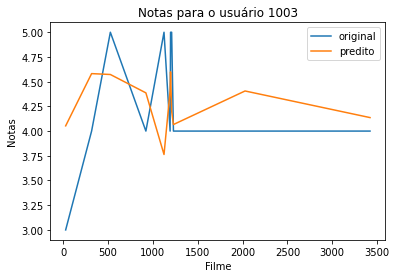

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


RMSE:
0.7981612443490497


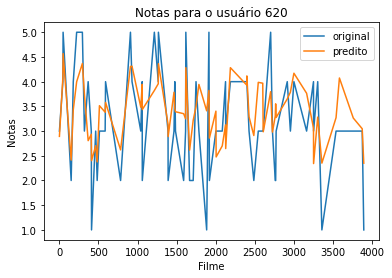

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


RMSE:
0.8946393366996525


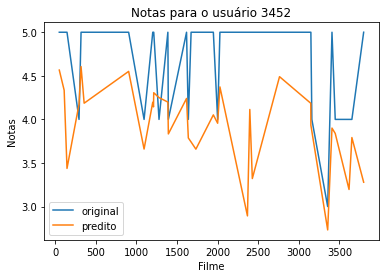

In [ ]:
for user_temp in users:
    user_original, user_predito = recomendacoes(X_train, userid=user_temp, rmse=True)

    user_original = user_original.sort_values(by=['movieid'])
    user_predito = user_predito.sort_values(by=['movieid'])

    plt.plot(user_original.movieid, user_original.rating)
    plt.plot(user_predito.movieid, user_predito.rating)
    
    title(f"Notas para o usuário {user_temp}")
    xlabel("Filme")
    ylabel("Notas")
    plt.legend(['original', 'predito'])

    rms = mean_squared_error(user_original.rating, user_predito.rating, squared=False)

    print('RMSE:')
    print(rms)
    plt.show()